In [27]:
import pandas as pd

df_sayo = pd.read_csv("Sayopillow (2).csv")
df_smartwatch = pd.read_csv("unclean_smartwatch_health_data.csv")

In [28]:
# Rename columns in smartwatch data to match SaYoPillow
column_mapping = {
    "Heart Rate (BPM)": "hr",
    "Blood Oxygen Level (%)": "bo",
    "Sleep Duration (hours)": "sr.1",
    "Stress Level": "sl"
}
df_smartwatch.rename(columns=column_mapping, inplace=True)

In [29]:
# Keep only relevant columns
common_columns = list(set(df_sayo.columns) & set(df_smartwatch.columns))
df_smartwatch = df_smartwatch[common_columns]

In [30]:
# Convert "sl" to numeric, forcing errors='coerce' to handle non-numeric values
if "sl" in df_smartwatch.columns:
    df_smartwatch["sl"] = pd.to_numeric(df_smartwatch["sl"], errors='coerce')
    # Apply stress level conversion (1-10 → 0-4 scale)
    df_smartwatch["sl"] = ((df_smartwatch["sl"] - 1) * (4 / 9)).round().astype("Int64")

In [31]:
# Merge datasets (row-wise)
df_extended = pd.concat([df_sayo, df_smartwatch], ignore_index=True)

In [32]:
# Save the extended dataset
extended_path = "Extended_SaYoPillow (3).csv"
df_extended.to_csv(extended_path, index=False)

In [33]:
# Display sample
print(df_extended.head())

      sr      rr       t      lm      bo    rem     sh     hr  sl
0  93.80  25.680  91.840  16.600  89.840  99.60  1.840  74.20   3
1  91.64  25.104  91.552  15.880  89.552  98.88  1.552  72.76   3
2  60.00  20.000  96.000  10.000  95.000  85.00  7.000  60.00   1
3  85.76  23.536  90.768  13.920  88.768  96.92  0.768  68.84   3
4  48.12  17.248  97.872   6.496  96.248  72.48  8.248  53.12   0


In [34]:
df_extended.tail()

,sr,rr,t,lm,bo,rem,sh,hr,sl
10625,NaN,NaN,NaN,NaN,98.931927,NaN,NaN,78.819386,3
10626,NaN,NaN,NaN,NaN,95.773035,NaN,NaN,48.632659,0
10627,NaN,NaN,NaN,NaN,97.945874,NaN,NaN,73.834442,1
10628,NaN,NaN,NaN,NaN,98.401058,NaN,NaN,NaN,3
10629,NaN,NaN,NaN,NaN,98.475606,NaN,NaN,70.063864,2


In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.metrics import accuracy_score, classification_report


warnings.filterwarnings("ignore")

#  Step 1: Load Data (Replace df_extended with actual dataset)
df = df_extended.copy()

In [36]:
#  Step 2: Convert all columns to numeric (force errors to NaN)
df = df.apply(pd.to_numeric, errors='coerce')

In [37]:
# Step 3: Impute Missing Values using Iterative Imputer
imputer = IterativeImputer(max_iter=10, random_state=42)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [38]:
# Step 4: Remove duplicate rows
df_imputed = df_imputed.drop_duplicates()

In [39]:
#  Step 5: Ensure target variable has no NaN values
df_imputed = df_imputed.dropna(subset=["sl"])  # Drop rows where target is NaN
df_imputed["sl"] = df_imputed["sl"].astype(int)  # Convert target variable to integer

In [40]:
#  Step 6: Split Features and Target Variable
X = df_imputed.drop(columns=["sl"])
y = df_imputed["sl"]

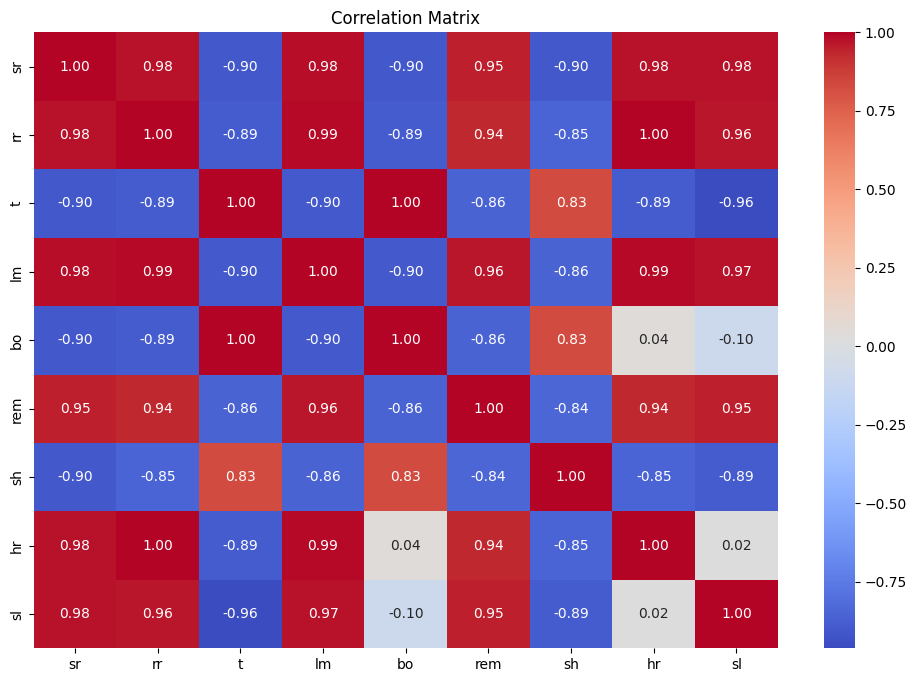

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [42]:
from sklearn.model_selection import train_test_split

# Train-test split without SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [43]:
from sklearn.ensemble import RandomForestClassifier
# Model 1: Random Forest
rf = RandomForestClassifier(n_estimators=5, random_state=42)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)
y_pred_rf = rf.predict(X_test)
print("\n Random Forest:")
print(accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Train Accuracy: 0.9951479289940829

 Random Forest:
0.9739706578324657
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       420
           1       0.97      0.92      0.94       461
           2       0.91      0.97      0.94       415
           3       1.00      1.00      1.00       408
           4       1.00      1.00      1.00       409

    accuracy                           0.97      2113
   macro avg       0.97      0.98      0.97      2113
weighted avg       0.97      0.97      0.97      2113



In [51]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Model 2: Naïve Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

# Train set predictions
y_train_pred_nb = nb.predict(X_train)
train_accuracy_nb = accuracy_score(y_train, y_train_pred_nb)
print("Train Accuracy:", train_accuracy_nb)

# Test set predictions
y_pred_nb = nb.predict(X_test)
print("\nNaïve Bayes:")
print(accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Train Accuracy: 0.941301775147929

Naïve Bayes:
0.9512541410317085
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       420
           1       0.96      0.91      0.93       461
           2       0.87      0.97      0.92       415
           3       0.98      0.91      0.94       408
           4       0.97      0.99      0.98       409

    accuracy                           0.95      2113
   macro avg       0.95      0.95      0.95      2113
weighted avg       0.95      0.95      0.95      2113



In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Model 3: Logistic Regression
lr = LogisticRegression(max_iter=20, random_state=42)
lr.fit(X_train, y_train)

# Train set predictions
y_train_pred_lr = lr.predict(X_train)
train_accuracy_lr = accuracy_score(y_train, y_train_pred_lr)
print("Train Accuracy:", train_accuracy_lr)

# Test set predictions
y_pred_lr = lr.predict(X_test)
print("\nLogistic Regression:")
print(accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Train Accuracy: 0.9474556213017752

Logistic Regression:
0.9469947941315665
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       420
           1       0.93      0.91      0.92       461
           2       0.87      0.92      0.90       415
           3       0.95      0.96      0.96       408
           4       1.00      0.95      0.97       409

    accuracy                           0.95      2113
   macro avg       0.95      0.95      0.95      2113
weighted avg       0.95      0.95      0.95      2113



In [46]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Model 4: Support Vector Machine (SVM) with adjusted parameters
svm = SVC(kernel='rbf', probability=True, random_state=42, C=5, gamma=0.05)  
svm.fit(X_train, y_train) 

# Train set predictions
y_train_pred_svm = svm.predict(X_train)
train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm)
print("Train Accuracy:", train_accuracy_svm)

# Test set predictions
y_pred_svm = svm.predict(X_test)
print("\nSVM:")
print("Test Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))



Train Accuracy: 0.9778698224852072

SVM:
Test Accuracy: 0.9777567439659253
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       420
           1       0.98      0.91      0.95       461
           2       0.91      1.00      0.95       415
           3       1.00      1.00      1.00       408
           4       1.00      1.00      1.00       409

    accuracy                           0.98      2113
   macro avg       0.98      0.98      0.98      2113
weighted avg       0.98      0.98      0.98      2113



In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Model 5: Decision Tree
dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X_train, y_train)  # Train on X_train, y_train (without SMOTE)

# Train set predictions
y_train_pred_dt = dt.predict(X_train)
train_accuracy_dt = accuracy_score(y_train, y_train_pred_dt)
print("Train Accuracy:", train_accuracy_dt)

# Test set predictions
y_pred_dt = dt.predict(X_test)
print("\nDecision Tree:")
print(accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


Train Accuracy: 0.9250887573964497

Decision Tree:
0.9214387127307146
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       420
           1       0.90      0.87      0.88       461
           2       0.85      0.91      0.88       415
           3       0.90      0.96      0.93       408
           4       0.98      0.92      0.95       409

    accuracy                           0.92      2113
   macro avg       0.92      0.92      0.92      2113
weighted avg       0.92      0.92      0.92      2113



In [48]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Model 6: XGBoost
xgb = XGBClassifier(n_estimators=10, learning_rate=0.1, max_depth=4, reg_lambda=10, reg_alpha=5, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)  # Train on X_train, y_train (without SMOTE)

# Train set predictions
y_train_pred_xgb = xgb.predict(X_train)
train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)
print("Train Accuracy:", train_accuracy_xgb)

# Test set predictions
y_pred_xgb = xgb.predict(X_test)
print("\nXGBoost:")
print(accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


Train Accuracy: 0.9474556213017752

XGBoost:
0.943208707998107
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       420
           1       0.91      0.89      0.90       461
           2       0.86      0.91      0.89       415
           3       0.97      0.96      0.97       408
           4       1.00      0.97      0.99       409

    accuracy                           0.94      2113
   macro avg       0.95      0.94      0.94      2113
weighted avg       0.94      0.94      0.94      2113



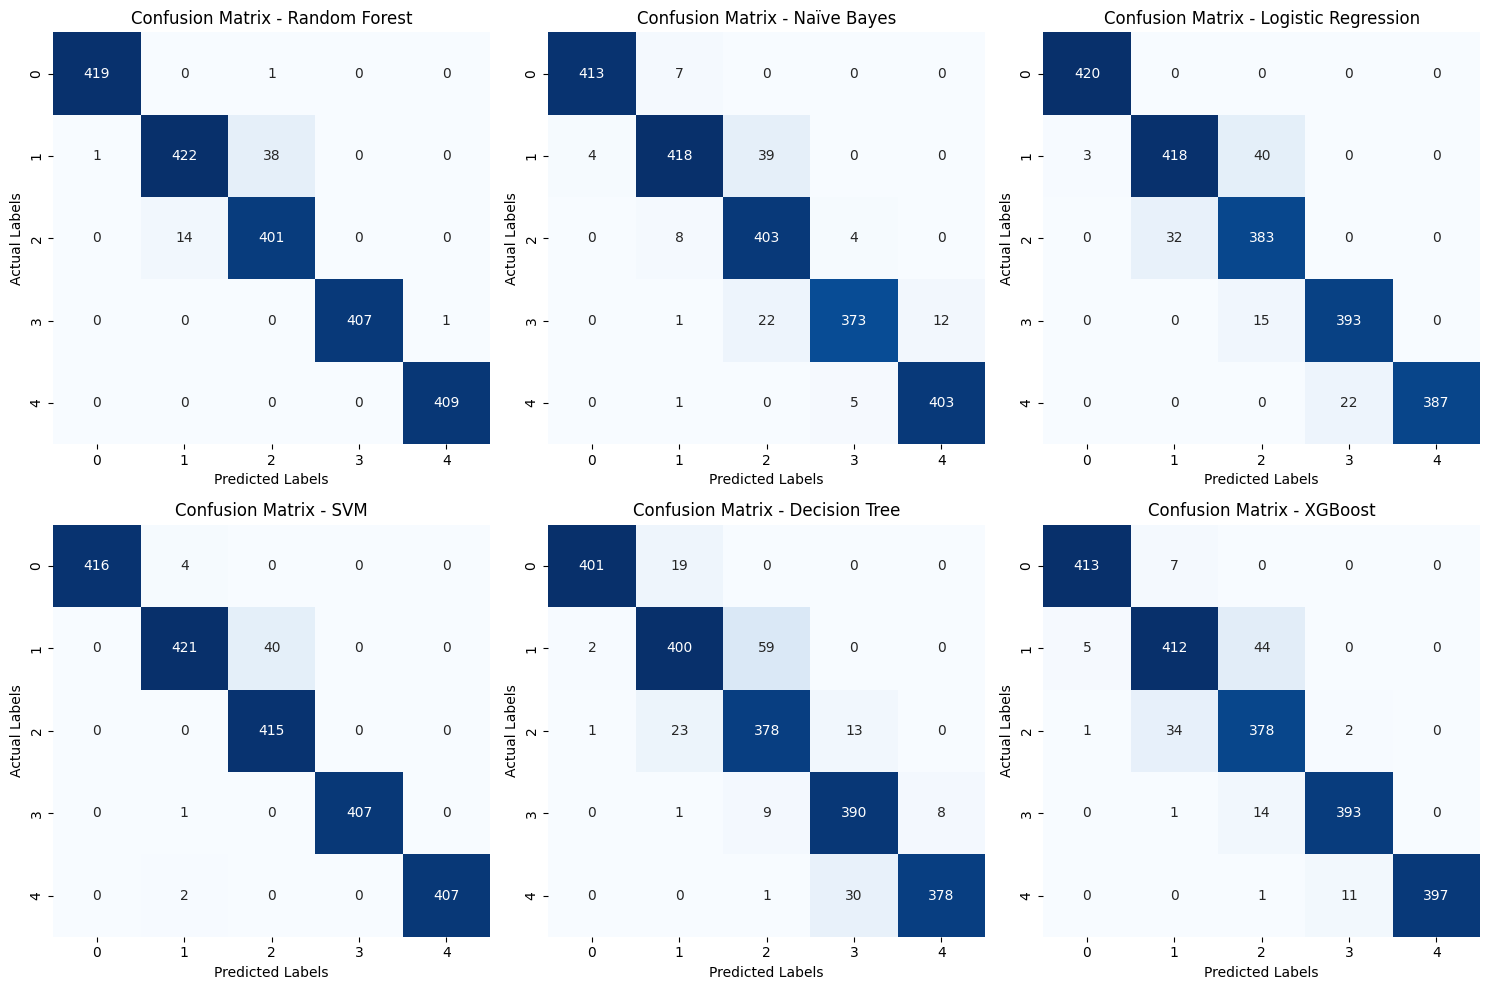

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Define model names and confusion matrices
model_names = ["Random Forest", "Naïve Bayes", "Logistic Regression", "SVM", "Decision Tree", "XGBoost"]
cms = [
    confusion_matrix(y_test, y_pred_rf),
    confusion_matrix(y_test, y_pred_nb),
    confusion_matrix(y_test, y_pred_lr),
    confusion_matrix(y_test, y_pred_svm),
    confusion_matrix(y_test, y_pred_dt),
    confusion_matrix(y_test, y_pred_xgb)
]

# Plot each confusion matrix separately
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust grid size (2 rows, 3 cols)
axes = axes.flatten()  # Flatten axes for easy iteration

for i, (ax, cm, model) in enumerate(zip(axes, cms, model_names)):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f"Confusion Matrix - {model}")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("Actual Labels")

plt.tight_layout()
plt.show()


In [49]:
import pickle
# Define the filename for the saved model
filename = 'svm_model.pkl'

# Open a file in write-binary mode and save the model
with open(filename, 'wb') as file:
    pickle.dump(svm, file)